<a href="https://colab.research.google.com/github/yblee110/jax-flax-book/blob/main/ch02_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp


example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")


[1, 'a', <object object at 0x7fde92f0e170>]   has 3 leaves: [1, 'a', <object object at 0x7fde92f0e170>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [2]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]


jax.tree_map(lambda x: x*2, list_of_lists)


[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [3]:
another_list_of_lists = list_of_lists
jax.tree_map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [4]:
import jax.numpy as jnp
from jax import random

def init_mlp_params(layer_widths, key):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=random.normal(key, shape=(n_in, n_out)) * jnp.sqrt(2/n_in), biases=jnp.ones(shape=(n_out,))
            )
       )
    return params

key = random.PRNGKey(42)
params = init_mlp_params([1, 128, 128, 1], key)


In [5]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [6]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)


LEARNING_RATE = 0.0001


@jax.jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    return jax.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads)


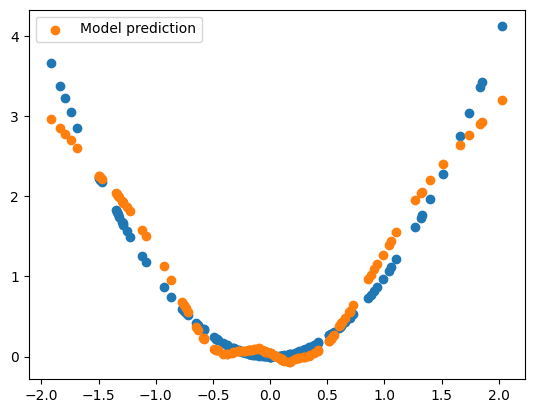

In [8]:
import matplotlib.pyplot as plt

key, subkey = random.split(key)
xs = jax.random.normal(subkey, shape=(128, 1))
ys = xs ** 2


for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()